In [294]:
# Self Organizing Map

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('thads2011_clean_v1.csv')

# Cleaning the dataset
dataset.drop(['FMTASSISTED'], axis=1,inplace=True)
dataset.drop(['FMTREGION'], axis=1,inplace=True)
dataset.drop(['FMTMETRO3'], axis=1,inplace=True)
dataset.drop(['ASSISTED'], axis=1,inplace=True)
dataset.drop(['VALUE'], axis=1,inplace=True)
dataset = dataset[dataset.ZINC2 != -6]
dataset.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)


In [297]:
dataset.columns.get_loc("COST06RELAMICAT")
#df.columns.get_loc("pear")
dataset['key'] = [i for i in range(len(dataset))]

First of all, all these houses are in input of our neural network. These input points are going to be mapped to a new output space and between the input space and the output space, we have this nerual network composed of neurons. Each neuron is instantiated as a vector of weights that is the size of each house's number of features. For each observation point, the output of this house is the neuron closest to the house. For each house, the winning node is the neuron most similar to the house. Then we use a neighborhood function, in this case, the gausian neighborhood function to update the weights of the neighbors of the winning node to move them closer to the point and we do that for all the houses in the input space and we repeat this many times. EAch time we repeat it, the output space decreases and loses dimensions. it reduces its dimension little by little and it reaches a point where the output space stops decreasing. That's the moment when we obtain our SOM in two dimensions with all the winning nodes that were identified.

When we think of rating unaffordability, perhaps we would think of outliers. For this, we would use the mean inter-neuron distance. (the mean of the euclidian distance between a neuron and all other neurons)
By doing this, we can detect outliers because outliers will be far compared to others.

We will then use an inverse mapping function to identify which houses originally in the input space are associated with this winning node, which is the outlier.

In [298]:
# Selecting X and Y
X = dataset.iloc[:,:].values
#Y = columns To be defined later on.

# Feature Scaling (usually compulsory for deep learning since there are high computations to make)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)
X.shape

(117157, 94)

In [299]:
# Training the SOM
from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len=94, sigma=1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

We will see a two dimensional grid that will contain all the final winning nodes and for each winning nodes, we will get the MID which is based on the distance around the node in a neighborhood radius specified by sigma. The higher the MID, the more the winning node will be far away from the neighborhood. 

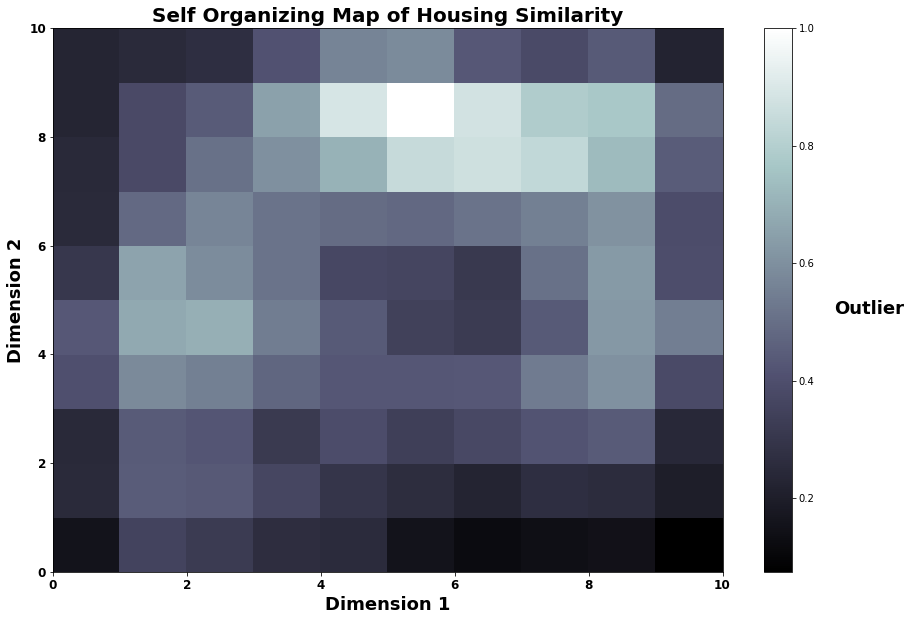

In [301]:
# Visualiing the results
plt.figure(figsize=(15,10))
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
cbar = colorbar()
cbar.set_label('Outlier', rotation=0,fontsize=18,fontweight='bold')
cbar.ax.get_yaxis().labelpad = 55
plt.title("Self Organizing Map of Housing Similarity",fontsize=20,fontweight='bold')
plt.xlabel("Dimension 1",fontsize=18,fontweight='bold')
plt.ylabel("Dimension 2",fontsize=18,fontweight='bold')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.savefig('LowGranularity.png')
plt.show()

Proceed to the inverse mapping to find the houses associated with the outliers.

In [82]:
mappings = som.win_map(X)

In [153]:
# We define these further up in the code when creating the SOM
rows = 10
cols = 10
# .................
#Get the Houses that are more likely to fail in actual affordability.

# Add indices to SOM values & sort by value
helper = np.concatenate(
    (som.distance_map().reshape(rows*cols, 1),         # the SOM map values
     np.arange(rows*cols).reshape(rows*cols, 1)),      # concatenated with an index
    axis=1)                                            # as a 2D matrix with 2 columns of data
helper = helper[helper[:, 0].argsort()][::-1]          # sort by first column (map values) and reverse (so top values are first)
# First we choose how many cells to take as outliers...
use_threshold = True   # toggle usage for calculating indices (pick cells that exceed threshold or use hardcoded number of cells)
top_cells = 100          # 4 out of 100 seems a valid idea, but ideally it might be chosen after inspecting the current SOM plot
threshold = 0.9        # Use threshold to select top cells
# Take indices that correspond to cells we're interested in
idx = helper[helper[:, 0] > threshold, 1] if use_threshold else helper[:top_cells, 1]
# Find the data entries assigned to cells corresponding to the selected indices
result_map = []
mappings = som.win_map(X)
for i in range(rows):
    for j in range(cols):
        if (i*rows+j) in idx:
            if len(result_map) == 0:                
                result_map = mappings[(i,j)]
            else:
                # Sometimes a cell contains no observations (customers)... weird
                # This will cause numpy to raise an exception so guard against that!
                if len(mappings[(i,j)]) > 0:
                    result_map = np.concatenate((result_map, mappings[(i,j)]), axis=0)
                    
# Finally, we have our outlier candidates
frauds = sc.inverse_transform(result_map)
 
# This is the list of potential cheaters (customer ids)
print(frauds[:, 0])

In [154]:
mappings = som.win_map(X)

In [160]:
frauds = mappings[(8,1)]
frauds = sc.inverse_transform(frauds)
fraudDf = pd.DataFrame(data = frauds)

In [166]:
# Hybrid Deep Learning Model
# Making an ANN
#fraudDf.iloc[:,49]

94

117157 Houses

84 Frauds

In [181]:
# Creating the Matrix of Features
houses = dataset.iloc[:,:].values

# Creating the Dependent Variable
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i,93] in frauds[:,93]:
        is_fraud[i] = 1

In [182]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
houses = sc.fit_transform(houses)

In [185]:
# Part 2 - Now let's make the ANN!

# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = 94))

# Adding the second hidden layer
#classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(houses, is_fraud, batch_size = 1, epochs = 2)

Epoch 1/2
117157/117157 [==============================] - 132s 1ms/step - loss: 0.0062 - acc: 0.9993
Epoch 2/2
117157/117157 [==============================] - 102s 870us/step - loss: 0.0039 - acc: 0.9992


In [282]:
# Part 3 - Making predictions and evaluating the model

# Predicting the probabilities of frauds
y_pred = classifier.predict(houses)
y_pred = np.concatenate((dataset.iloc[:,93:94], y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

In [285]:
pd.DataFrame(data = y_pred)

,0,1
0,71484.0,0.000000e+00
1,97104.0,0.000000e+00
2,50175.0,0.000000e+00
3,45.0,0.000000e+00
4,64964.0,0.000000e+00
5,97931.0,0.000000e+00
6,96778.0,0.000000e+00
7,107888.0,0.000000e+00
8,98248.0,0.000000e+00
9,97105.0,0.000000e+00
